In [4]:
import time
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import StratifiedKFold

def gen_rand(n_size=1):
    '''
    This function return a n_size-dimensional random vector.
    '''
    return np.random.random(n_size)

class NN_DE(object):
    
    def __init__(self, n_pop=10, n_neurons=5, F=0.2, Cr=0.9, p=1, change_scheme=True ,scheme='rand',
                 bounds=[-1, 1], max_sp_evals=np.int(1e5), sp_tol=1e-2):
        #self.n_gens=n_gens
        self.n_pop=n_pop
        self.n_neurons=n_neurons
        self.F=F*np.ones(self.n_pop)
        self.Cr=Cr*np.ones(self.n_pop)
        self.bounds=bounds
        self.p=p
        self.scheme=scheme
        self.change_schame=change_scheme
        self.max_sp_evals=max_sp_evals
        self.sp_tol = sp_tol
        self.sp_evals=0
        self.interactions=0
        # Build generic model
        model = Sequential()
        model.add(Dense(self.n_neurons, input_dim=100, activation='tanh'))
        model.add(Dense(1, activation='tanh'))
        model.compile( loss='mean_squared_error', optimizer = 'rmsprop', metrics = ['accuracy'] )
        self.model=model
        self.change_schame=False
        self.n_dim=model.count_params()
        #self.population=NN_DE.init_population(self, pop_size=self.n_pop,
        #                                             dim=self.n_dim, bounds=self.bounds)
        #self.train_dataset= train_dataset
        #self.test_dataset= test_dataset
        
    def init_population(self, pop_size, dim, bounds=[-1,1]):
        '''
        This function initialize the population to be use in DE
        Arguments:
        pop_size - Number of individuals (there is no default value to this yet.).
        dim - dimension of the search space (default is 1).
        bounds - The inferior and superior limits respectively (default is [-1, 1]).
            '''
        return np.random.uniform(low=bounds[0], high=bounds[1], size=(pop_size, dim))

    def keep_bounds(self, pop, bounds, idx):
        '''
        This function keep the population in the seach space
        Arguments:
        pop - Population;
        bounds - The inferior and superior limits respectively
        '''
        #up_ = np.where(pop>bounds[1])
        #down_ = np.where(pop<bounds[1])
        #best_ = pop[idx]
        #print(pop[pop<bounds[0]])
        #print(down_)
        #print(best_.shape)
        pop[pop<bounds[0]] = bounds[0]; pop[pop>bounds[1]] = bounds[1]
        #pop[pop<bounds[0]] = 0.5*(bounds[0]+best_[down_]); pop[pop>bounds[1]] = 0.5*(bounds[1]+best_[up_])
        return pop

    # Define the Fitness to be used in DE
    def sp_fitness(self, target, score):
        '''
        Calculate the SP index and return the index of the best SP found

        Arguments:
        target: True labels
        score: the predicted labels
        '''
        from sklearn.metrics import roc_curve

        fpr, tpr, thresholds = roc_curve(target, score)
        jpr = 1. - fpr
        sp = np.sqrt( (tpr  + jpr)*.5 * np.sqrt(jpr*tpr) )
        idx = np.argmax(sp)
        return sp[idx], tpr[idx], fpr[idx]#sp, idx, sp[idx], tpr[idx], fpr[idx]

    def convert_vector_weights(self, pop, nn_model):
        
        model = nn_model
        
        generic_weights = model.get_weights()
        hl_lim = generic_weights[0].shape[0]*generic_weights[0].shape[1]
        
        w = []
        hl = pop[:hl_lim]
        ol = pop[hl_lim+generic_weights[1].shape[0]:hl_lim+generic_weights[1].shape[0]+generic_weights[1].shape[0]] 
        w.append(hl.reshape(generic_weights[0].shape))
        w.append(pop[hl_lim:hl_lim+generic_weights[1].shape[0]])
        w.append(ol.reshape(generic_weights[2].shape))
        w.append(np.array(pop[-1]).reshape(generic_weights[-1].shape))
        
        return w
        
    def set_weights_to_keras_model_and_compute_fitness(self,pop, data, test_data, nn_model):
        '''
        This function will create a generic model and set the weights to this model and compute the fitness.
        Arguments:
        pop - The population of weights.
        data - The samples to be used to test.
        '''
        fitness = np.zeros((pop.shape[0],3))
        test_fitness = np.zeros((pop.shape[0],3))
        model=nn_model
        
        if pop.shape[0]!= self.n_pop:
            #print('Local seach ind...')
            w = NN_DE.convert_vector_weights(self, pop=pop, nn_model=model)
            model.set_weights(w)
            y_score = model.predict(data[0])
            fitness = NN_DE.sp_fitness(self, target=data[1], score=y_score)
            
            # Compute the SP for test in the same calling to minimeze the evals
            test_y_score = model.predict(test_data[0])
            test_fitness = NN_DE.sp_fitness(self, target=test_data[1], score=test_y_score)
            return fitness, test_fitness
        
        for ind in range(pop.shape[0]):
            w = NN_DE.convert_vector_weights(self, pop=pop[ind], nn_model=model)
            model.set_weights(w)
            y_score = model.predict(data[0])
            fitness[ind] = NN_DE.sp_fitness(self, target=data[1], score=y_score)
            
            # Compute the SP for test in the same calling to minimeze the evals
            test_y_score = model.predict(test_data[0])
            test_fitness[ind] = NN_DE.sp_fitness(self, target=test_data[1], score=test_y_score)
            #print('Population ind: {} - SP: {} - PD: {} - PF: {}'.format(ind, fitness[ind][0], fitness[ind][1], fitness[ind][2]))
        return fitness, test_fitness


    def evolution(self, train_dataset, test_dataset):
        
        self.population=NN_DE.init_population(self, pop_size=self.n_pop,
                                              dim=self.n_dim, bounds=self.bounds)
        r_NNDE = {}
        fitness, test_fitness = NN_DE.set_weights_to_keras_model_and_compute_fitness(self, pop=self.population,
                                                                       data=train_dataset,
                                                                       test_data=test_dataset,
                                                                       nn_model=self.model)
        best_idx = np.argmax(fitness[:,0])
        
        # Create the vectors F and Cr to be adapted during the interactions
        NF = np.zeros_like(self.F)
        NCr = np.zeros_like(self.Cr)
        # Create a log
        r_NNDE['log'] = []
        r_NNDE['log'].append((self.sp_evals, fitness[best_idx], np.mean(fitness, axis=0),
                             np.std(fitness, axis=0), np.min(fitness, axis=0), np.median(fitness, axis=0), self.F, self.Cr))

        r_NNDE['test_log'] = []
        r_NNDE['test_log'].append((self.sp_evals, test_fitness[best_idx], np.mean(test_fitness, axis=0),
                             np.std(test_fitness, axis=0), np.min(test_fitness, axis=0), np.median(test_fitness, axis=0), self.F, self.Cr))

        while self.sp_evals < self.max_sp_evals:
            # ============ Mutation Step ===============
            mutant = np.zeros_like(self.population)
            for ind in range(self.population.shape[0]):
                if gen_rand() < 0.1:
                    NF[ind] = 0.2 +0.2*gen_rand()
                else:
                    NF[ind] = self.F[ind]
                tmp_pop = np.delete(self.population, ind, axis=0)
                choices = np.random.choice(tmp_pop.shape[0], 1+2*self.p, replace=False)
                diffs = 0
                for idiff in range(1, len(choices), 2):
                    diffs += NF[ind]*((tmp_pop[choices[idiff]]-tmp_pop[choices[idiff+1]]))
                    if self.scheme=='rand':
                        mutant[ind] = tmp_pop[choices[0]] + diffs
                    elif self.scheme=='best':
                        mutant[ind] = self.population[best_idx] + diffs
            # keep the bounds
            mutant = NN_DE.keep_bounds(self, mutant, bounds=[-1,1], idx=best_idx)

            # ============ Crossover Step ============= 
            trial_pop = np.copy(self.population)
            K = np.random.choice(trial_pop.shape[1])
            for ind in range(trial_pop.shape[0]):
                if gen_rand() < 0.1:
                    NCr[ind] = 0.8 +0.2*gen_rand()
                else:
                    NCr[ind] = self.Cr[ind]
                for jnd in range(trial_pop.shape[1]):
                    if jnd == K or gen_rand()<NCr[ind]:
                        trial_pop[ind][jnd] = mutant[ind][jnd]
            # keep the bounds
            trial_pop = NN_DE.keep_bounds(self, trial_pop, bounds=[-1,1], idx=best_idx)

            trial_fitness, test_fitness = NN_DE.set_weights_to_keras_model_and_compute_fitness(self, pop=trial_pop,
                                                                                               data=train_dataset,
                                                                                               test_data=test_dataset,
                                                                                               nn_model=self.model)
            self.sp_evals += self.population.shape[0]
            
            # ============ Selection Step ==============
            winners = np.where(trial_fitness[:,0]>fitness[:,0])
        
            # Auto-adtaptation of F and Cr like NSSDE
            self.F[winners] = NF[winners]
            self.Cr[winners] = NCr[winners]
            
            # Greedy Selection
            fitness[winners] = trial_fitness[winners]
            self.population[winners] = trial_pop[winners]
            best_idx = np.argmax(fitness[:,0])
            
            if self.interactions > 0.95*self.max_sp_evals/self.n_pop:
                print('=====Interaction: {}====='.format(self.interactions+1))
                print('Best NN found - SP: {} / PD: {} / FA: {}'.format(fitness[best_idx][0],
                                                                        fitness[best_idx][1],
                                                                        fitness[best_idx][2]))
            
                print('Test > Mean - SP: {} +- {}'.format(np.mean(test_fitness,axis=0)[0],
                                                                    np.std(test_fitness,axis=0)[0]))
                
            # Local search like NSSDE 
            a_1 = gen_rand(); a_2 = gen_rand()
            a_3 = 1.0 - a_1 - a_2
            
            k, r1, r2 = np.random.choice(self.population.shape[0], size=3)
            V = np.zeros_like(self.population[k])
            for jdim in range(self.population.shape[1]):
                V[jdim] = a_1*self.population[k][jdim] + a_2*self.population[best_idx][jdim] + a_3*(self.population[r1][jdim] - self.population[r2][jdim])
                V = NN_DE.keep_bounds(self, V, bounds=self.bounds, idx=best_idx)
            
            
            V_train_fitness, V_test_fitness = NN_DE.set_weights_to_keras_model_and_compute_fitness(self, pop=V,
                                                                                        data=train_dataset,
                                                                                        test_data=test_dataset,
                                                                                        nn_model=self.model)
            
            self.sp_evals += 1
            if V_train_fitness[0] > fitness[k][0]:
                #print('Found best model using local search...')
                self.population[k] = V
                if V_train_fitness[0] > fitness[best_idx][0]:
                    best_idx = k
            
            # ======== Done interaction ===========
            self.interactions += 1
            
            r_NNDE['log'].append((self.sp_evals, fitness[best_idx], np.mean(fitness, axis=0),
                             np.std(fitness, axis=0), np.min(fitness, axis=0), np.median(fitness, axis=0), self.F, self.Cr))
            
            r_NNDE['test_log'].append((self.sp_evals, test_fitness[best_idx], np.mean(test_fitness, axis=0),
                             np.std(test_fitness, axis=0), np.min(test_fitness, axis=0), np.median(test_fitness, axis=0), self.F, self.Cr))
            
            #print('Fitness: ', fitness[:,0])
            #print('Mean: ',np.mean(fitness[:,0]))
            if np.abs(np.mean(fitness[:,0])-fitness[best_idx][0])< self.sp_tol:
                print('Stop by Mean Criteria...')
                break
        # Compute the test
        #test_fitness = NN_DE.set_weights_to_keras_model_and_compute_fitness(self, pop=self.population,
        #                                                               data=self.test_dataset, nn_model=self.model)

        r_NNDE['champion weights'] = NN_DE.convert_vector_weights(self, self.population[best_idx], self.model)
        r_NNDE['model'] = self.model
        r_NNDE['best index'] = best_idx
        r_NNDE['Best NN'] = fitness[best_idx]
        r_NNDE['train_fitness'] = fitness
        r_NNDE['test_fitness'] = test_fitness
        r_NNDE['population'] = self.population,
        return r_NNDE

Using Theano backend.
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/home/micael/anaconda3/envs/CodeLab/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/home/micael/anaconda3/envs/CodeLab/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/home/micael/anaconda3/envs/CodeLab/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 99, in init_dev
    **args)
  File "pygpu/gpuarray.pyx", line 658, in pygpu.gpuarray.init
  File "pygpu/gpuarray.pyx", line 587, in pygpu.gpuarray.pygpu_init
pygpu.gpuarray.GpuArrayException: b'Could not load "libcuda.so": libnvidia-fatbinaryloader.so.384.130: cannot open shared object file: No such file or directory'


In [5]:
data = np.load('/home/micael/MyWorkspace/RingerRepresentation/2channels/data17-18_13TeV.sgn_lhmedium_probes.EGAM2.bkg.vetolhvloose.EGAM7.samples.npz')
sgn = data['signalPatterns_etBin_2_etaBin_0']
bkg = data['backgroundPatterns_etBin_2_etaBin_0']

# Equilibrate the classes to make a controled tests
bkg = bkg[np.random.choice(bkg.shape[0], size=sgn.shape[0]),:]
print(sgn.shape, bkg.shape)

sgn_trgt = np.ones(sgn.shape[0])
bkg_trgt = -1*np.ones(bkg.shape[0])

sgn_normalized = np.zeros_like(sgn)
for ind in range(sgn.shape[0]):
    sgn_normalized[ind] = sgn[ind]/np.abs(np.sum(sgn[ind]))
    
bkg_normalized = np.zeros_like(bkg)
for ind in range(bkg.shape[0]):
    bkg_normalized[ind] = bkg[ind]/np.abs(np.sum(bkg[ind]))

data_ = np.append(sgn_normalized, bkg_normalized, axis=0)
trgt = np.append(sgn_trgt, bkg_trgt)

(6988, 100) (6988, 100)


In [6]:
skf = StratifiedKFold(n_splits=10)

In [7]:
CVO = list(skf.split(data_, trgt))

In [8]:
def worker(proc_id, result_dict):
    print('Work Fold: '+ str(proc_id+1))
    train_index, test_index = CVO[proc_id]
    return_dict['Fold {}'.format(proc_id+1)] = nn_de.evolution(train_dataset=(data_[train_index], trgt[train_index]),
                                                           test_dataset=(data_[test_index], trgt[test_index]))
    print('Done Fold: '+ str(proc_id+1))

In [10]:
%%time
import multiprocessing

all_results = {}
for ineuron in range(5, 11):
    inicio = time.time()
    nn_de = NN_DE(n_pop=20, n_neurons=ineuron, max_sp_evals=2e3, scheme='rand', sp_tol=1e-3)
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    jobs = []
    for ifold in range(len(CVO)):
        p = multiprocessing.Process(target=worker, args=(ifold,return_dict))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()

    
    return_dict = dict(return_dict)
    fim=time.time()
    print('Neuron: {} | Demorou - {} segundos'.format(ineuron, fim-inicio))
    return_dict['elapsed_time'] = fim-inicio
    all_results[ineuron] = return_dict
#print('Demorou - {} segundos'.format(fim-inicio))

Work Fold: 1
Work Fold: 3
Work Fold: 2
Work Fold: 5
Work Fold: 4
Work Fold: 7
Work Fold: 6
Work Fold: 9
Work Fold: 8
Work Fold: 10


INFO (theano.gof.compilelock): Waiting for existing lock by process '20463' (I am process '20473')
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '20463' (I am process '20474')
INFO (theano.gof.compilelock): Waiting for existing lock by process '20463' (I am process '20489')
INFO (theano.gof.compilelock): Waiting for existing lock by process '20463' (I am process '20478')
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '20463' (I am process '20492')
INFO (theano.gof.compilelock): Waiting for existing lock by process '20463' (I am process '20476')
INFO (theano.gof.compilelock): Waiting for

Stop by Mean Criteria...
Done Fold: 3


INFO (theano.gof.compilelock): Waiting for existing lock by process '20473' (I am process '20474')
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '20473' (I am process '20478')
INFO (theano.gof.compilelock): Waiting for existing lock by process '20473' (I am process '20489')
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '20473' (I am process '20492')
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock b

Stop by Mean Criteria...
Done Fold: 2


INFO (theano.gof.compilelock): Waiting for existing lock by process '20474' (I am process '20489')
INFO (theano.gof.compilelock): Waiting for existing lock by process '20474' (I am process '20478')
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '20474' (I am process '20476')
INFO (theano.gof.compilelock): Waiting for existing lock by process '20474' (I am process '20492')
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock b

Stop by Mean Criteria...
Done Fold: 4


INFO (theano.gof.compilelock): Waiting for existing lock by process '20489' (I am process '20476')
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '20489' (I am process '20492')
INFO (theano.gof.compilelock): Waiting for existing lock by process '20489' (I am process '20478')
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '20489' (I am process '20490')
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): To manually release the loc

Stop by Mean Criteria...
Done Fold: 1


INFO (theano.gof.compilelock): Waiting for existing lock by process '20476' (I am process '20478')
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '20476' (I am process '20490')
INFO (theano.gof.compilelock): Waiting for existing lock by process '20476' (I am process '20492')
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir


Stop by Mean Criteria...
Done Fold: 8


INFO (theano.gof.compilelock): Waiting for existing lock by process '20478' (I am process '20490')
INFO (theano.gof.compilelock): Waiting for existing lock by process '20478' (I am process '20492')
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir


Stop by Mean Criteria...
Done Fold: 6
Stop by Mean Criteria...
Done Fold: 5


INFO (theano.gof.compilelock): Waiting for existing lock by process '20490' (I am process '20492')
INFO (theano.gof.compilelock): To manually release the lock, delete /tmp/micael/theano.NOBACKUP/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir


Stop by Mean Criteria...
Done Fold: 10
Stop by Mean Criteria...
Done Fold: 7
Stop by Mean Criteria...
Done Fold: 9
Neuron: 5 | Demorou - 79.9147686958313 segundos
Work Fold: 1
Work Fold: 2
Work Fold: 3
Work Fold: 4
Work Fold: 6
Work Fold: 5
Work Fold: 7
Work Fold: 10
Work Fold: 8
Work Fold: 9
Stop by Mean Criteria...
Done Fold: 7
Stop by Mean Criteria...
Done Fold: 5
Stop by Mean Criteria...
Done Fold: 10
Stop by Mean Criteria...
Done Fold: 8
Stop by Mean Criteria...
Done Fold: 9
Stop by Mean Criteria...
Done Fold: 2
Stop by Mean Criteria...
Done Fold: 6
Stop by Mean Criteria...
Done Fold: 1
Stop by Mean Criteria...
Done Fold: 3
Stop by Mean Criteria...
Done Fold: 4
Neuron: 6 | Demorou - 107.03001356124878 segundos
Work Fold: 1
Work Fold: 2
Work Fold: 3
Work Fold: 4
Work Fold: 5
Work Fold: 6
Work Fold: 9
Work Fold: 8
Work Fold: 7
Work Fold: 10
Stop by Mean Criteria...
Done Fold: 7
Stop by Mean Criteria...
Done Fold: 3
Stop by Mean Criteria...
Done Fold: 9
Stop by Mean Criteria...
Done 

In [17]:
all_results[6].keys()

dict_keys(['Fold 7', 'Fold 5', 'Fold 10', 'Fold 8', 'Fold 9', 'Fold 2', 'Fold 6', 'Fold 1', 'Fold 3', 'Fold 4', 'elapsed_time'])

In [40]:
train_time = []
for ineuron in all_results.keys():
    train_time.append(all_results[ineuron]['elapsed_time'])

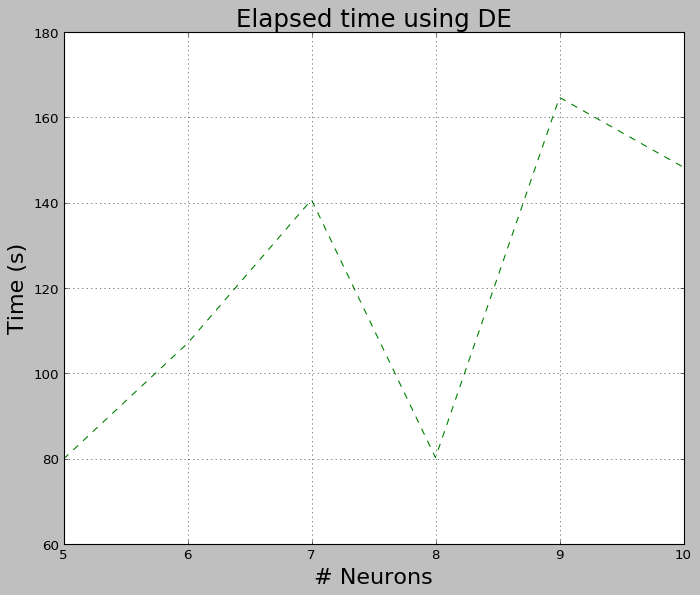

In [44]:
import matplotlib.pyplot as plt
plt.style.use('_classic_test')

plt.figure(figsize=(10, 8))
plt.plot(np.arange(5, 11), train_time, '--', c='g')
plt.title('Elapsed time using DE', fontsize=22)
plt.xlabel('# Neurons', fontsize=20)
plt.ylabel('Time (s)',  fontsize=20)
plt.grid()
plt.savefig('Elapsed_time.pdf')
plt.savefig('Elapsed_time.png', dpi=150)
plt.show()

In [19]:
r = {}
for ineuron in all_results.keys():
    print(ineuron)
    r[ineuron] = []
    for ifold in all_results[ineuron].keys():
        if ifold == 'elapsed_time':
            continue
        print(ifold, '>', all_results[ineuron][ifold]['test_fitness'][all_results[ineuron][ifold]['best index']])
        r[ineuron].append(all_results[ineuron][ifold]['test_fitness'][all_results[ineuron][ifold]['best index']])
    print('Neuron: {} - SP/PD/FA: {} +- {}'.format(ineuron, np.around(100*np.mean(r[ineuron], axis=0),4), np.around(100*np.std(r[ineuron], axis=0),4)))

5
Fold 3 > [ 0.89412933  0.89842632  0.11015737]
Fold 2 > [ 0.87764028  0.88984263  0.13447783]
Fold 4 > [ 0.86889715  0.89556509  0.15736767]
Fold 1 > [ 0.92270186  0.93562232  0.09012876]
Fold 8 > [ 0.89484964  0.89413448  0.10443491]
Fold 6 > [ 0.85908068  0.85550787  0.13733906]
Fold 5 > [ 0.90676113  0.93705293  0.1230329 ]
Fold 10 > [ 0.88063188  0.92120344  0.15902579]
Fold 7 > [ 0.91340731  0.92560801  0.09871245]
Fold 9 > [ 0.92548757  0.93266476  0.08166189]
Neuron: 5 - SP/PD/FA: [ 89.4359  90.8563  11.9634] +- [ 2.1564  2.494   2.5675]
6
Fold 7 > [ 0.90905335  0.92846924  0.11015737]
Fold 5 > [ 0.90367248  0.94563662  0.13733906]
Fold 10 > [ 0.92903325  0.94269341  0.08452722]
Fold 8 > [ 0.92472324  0.94992847  0.10014306]
Fold 9 > [ 0.92611678  0.94555874  0.09312321]
Fold 2 > [ 0.92770416  0.94134478  0.08583691]
Fold 6 > [ 0.91628542  0.92560801  0.09298999]
Fold 1 > [ 0.92193032  0.94134478  0.09728183]
Fold 3 > [ 0.92554112  0.94134478  0.09012876]
Fold 4 > [ 0.9241104 

In [ ]:
r_ = {}
for ifold in return_dict.keys():
    print(len(return_dict[ifold]['log']))
    checks = list(range(0,len(return_dict[ifold]['log'])))
    r_[ifold]={}
    r_[ifold]['train'] = []
    r_[ifold]['test'] = []
    for icheck in checks:
        #print(ifold, '>', return_dict[ifold]['log'][icheck][2])
        r_[ifold]['train'].append(return_dict[ifold]['log'][icheck][2])
        r_[ifold]['test'].append(return_dict[ifold]['test_log'][icheck][2])

In [ ]:
np.array(r_['Fold 1']['train'])[:,0]

In [ ]:
merits = {
    'SP'  : 'SP Index',
    'PD'  : 'PD',
    'FA'  : 'FA'
}

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('_classic_test')

folds = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Fold 6', 'Fold 7', 'Fold 8', 'Fold 9', 'Fold 10']
#x_axis = np.array([0., 20, 100, 1000,2000,3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])

for idx, imerit in enumerate(merits.keys()):
    print('Plot: ', imerit)
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15,5))
    for ifold in folds:

        ax1.plot(np.array(r_[ifold]['train'])[:,idx], label=ifold)
        ax1.legend(fontsize='large', loc='best')
        ax1.set_title(merits[imerit]+' - Train', fontsize=15)
        ax1.set_xlabel('Interactions', fontsize=10)
        ax1.set_ylabel('Mean '+merits[imerit], fontsize=10)
        ax1.grid(True)

        ax2.plot(np.array(r_[ifold]['test'])[:,idx], label=ifold)
        ax2.legend(fontsize='large', loc='best')
        ax2.set_title(merits[imerit]+' - Test', fontsize=15)
        ax2.set_xlabel('Interactions', fontsize=10)
        ax2.set_ylabel('Mean '+merits[imerit], fontsize=10)
        ax2.grid(True)
    plt.savefig(merits[imerit]+'.rand1bin.2000evals.withLS.MeanStopCriteria.pdf',)
    plt.savefig(merits[imerit]+'.rand1bin.2000evals.withLS.MeanStopCriteria.png', dpi=150)
    plt.show()

In [ ]:
print(type(return_dict))
return_dict = dict(return_dict)
print(type(return_dict))

In [ ]:
return_dict.keys()

In [ ]:
return_dict['CVO'] = CVO

In [ ]:
return_dict['CVO']

In [45]:
import pickle

with open('nnde.5-10neurons.rand1bin.2000evals.withLS.MeanStopCriteria.pickle', 'wb') as handle:
    pickle.dump(all_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Here begin the Backpropagation

Steps:

1. Get the champions and set the model.
2. Fit the model in each fold.
3. Get the results.

In [ ]:
number_of_epoch = 100

In [ ]:
%%time
for i in range(number_of_epoch):
    pass

In [ ]:
return_dict['Fold 1'].keys()

In [ ]:
return_dict['Fold 1']['champion weights']

In [ ]:
import time
inicio = time.time()
nn_de = NN_DE(n_pop=20, max_sp_evals=1e4, scheme='rand')
resultado = {}
for ifold, (train_index, test_index) in enumerate(CVO):
    print("TRAIN:", train_index, "TEST:", test_index, "Fold: ", ifold)
    resultado['Fold {}'.format(ifold+1)] = nn_de.evolution(train_dataset=(data_[train_index], trgt[train_index]),
                                                           test_dataset=(data_[test_index], trgt[test_index]))
fim=time.time()

print('Demorou - {} segundos'.format(fim-inicio))

In [ ]:
resultado['Fold 1']

In [ ]:
resultado = {}
for train_index, test_index in skf.split(data_, trgt):
    print("TRAIN:", train_index, "TEST:", test_index)
    

In [ ]:
teste = NN_DE(n_pop=20,max_sp_evals=2e3, scheme='rand', sp_tol=0.1)

In [ ]:
ev = teste.evolution(train_dataset=(data_, trgt), test_dataset=(data_, trgt))

In [ ]:
ev.keys()

In [ ]:
ev['log'][-1]

In [ ]:
np.mean(ev['fitness'],axis=0), np.std(ev['fitness'], axis=0)

In [ ]:
np.argmin(ev['fitness'][:,0]), ev['best index']

In [ ]:
ev['fitness'][ev['best index']], ev['fitness'][np.argmin(ev['fitness'][:,0])]